Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0008   4.393260e+00   7.564745e-02 
    00s07  0018   4.325718e+00   7.313156e-05 
    00s09  0024   4.325553e+00   1.705994e-06 
    00s12  0034   4.325551e+00   2.702627e-08 
Runtime:     00s12
Optimization status: Converged

[[-10.]
 [ -5.]
 [  0.]
 [  5.]
 [ 10.]
 [-10.]
 [ -5.]
 [  0.]
 [  5.]
 [ 10.]
 [-10.]
 [ -5.]
 [  0.]
 [  5.]
 [ 10.]
 [-10.]
 [ -5.]
 [  0.]
 [  5.]
 [ 10.]
 [-10.]
 [ -5.]
 [  0.]
 [  5.]
 [ 10.]]
[[-10.]
 [-10.]
 [-10.]
 [-10.]
 [-10.]
 [ -5.]
 [ -5.]
 [ -5.]
 [ -5.]
 [ -5.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  0.]
 [  5.]
 [  5.]
 [  5.]
 [  5.]
 [  5.]
 [ 10.]
 [ 10.]
 [ 10.]
 [ 10.]
 [ 10.]]
[[ 0.38416159]
 [ 0.54168291]
 [ 0.0489369 ]
 [-0.40963039]
 [-0.20258107]
 [ 0.47281116]
 [ 0.96704019]
 [-0.00756786]
 [-0.92469671]
 [-0.50114512]
 [ 0.00720218]
 [ 0.07271368]
 [ 0.03805189]
 [ 0.00608375]
 [ 0.02219316]
 [-0.50499133]
 [-0.84483181]
 [-0.0102579

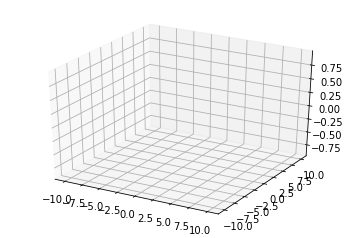

'\nk = GPy.kern.RBF(input_dim=1,lengthscale=0.2)\nX = np.linspace(0.,1.,500)\n# 500 points evenly spaced over [0,1]\nX = X[:,None]\n# reshape X to make it n*D\nmu = np.zeros((500))\n# vector of the means\nC = k.K(X,X)\n# covariance matrix\n# Generate 20 sample path with mean mu and covariance C\nZ = np.random.multivariate_normal(mu,C,20)\nprint Z.shape\nplt.figure()\n# open new plotting window\nfor i in range(20):\n    plt.plot(X[:],Z[i,:])\n    \nplt.show()\n'

In [133]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
import numpy as np
import math
import os

import GPy


class Environment:
    def __init__(self, ranges, gp):
        # Expect ranges to be a 4-tuple consisting of xmin, xmax, ymin, and ymax
        self.xmin = float(ranges[0])
        self.xmax = float(ranges[1])
        self.ymin = float(ranges[2])
        self.ymax = float(ranges[3]) 
        
        print "Environment onitialized with bounds X: (", self.xmin, ",", self.xmax, ")  Y:(", self.ymin, ",", self.ymax, ")" 
    
class GPModel:
    def __init__(self, xvals, yvals, lengthscale, variance, dimension = 2, noise = 0.05, kernel = 'rbf'):
        # The dimension of the evironment
        self.dim = dimension
        # The noise parameter of the sensor
        self.nosie = nosie
        
        if kernel == 'rbf':
            self.kern = GPy.kern.RBF(input_dim = self.dim, lengthscale = lengthscale, variance = variance)
        else:
            raise ValueError('Kernel type must by \'rbf\'')
        
        if os.path.isfile('kernel_model.npy'):
            print "Loading kernel parameters from file"
            
            # Initialize GP model from file
            self.m = GPy.models.GPRegression(np.array(xavls), np.array(yvals), self.kern, initialize = False)
            self.m.update_model(False)
            self.m.initialize_parameter()
            self.m[:] = np.load('kernel_model.npy')
            self.m.update_model(True)
            
        else:
            print "Optimizing kernel parameters"
            # Initilaize GP model
            self.m = GPy.models.GPRegression(np.array(xvals), np.array(yvals), self.kern)
            
            # Constrain the hyperparameters during optmization
            self.m.constrain_positive('')
            self.m['rbf.variance'].constrain_bounded(0.01, 10)
            self.m['rbf.lengthscale'].constrain_bounded(0.01, 10)
            self.m['Gaussian_noise.variance'].constrain_fixed(1e-2)
            
            # Train the kernel hyperparameters
            self.m.optimize_restarts(num_restarts = 2, messages = True)
            
            # Save the hyperparemters to file
            np.save('kernel_model.npy', self.m.param_array)
            
        # Visualize the learned GP kernel
        def kernel_plot(self):
            _ = self.kern.plot()
            plt.ylim([-1, 1])
            plt.xlim([-1, 1])
            plt.show()

            

# Generate data from a Gaussian mixture model            
def generateGPData(ranges, training_points):
    # Sample inputs and outputs 2D data
    np.random.seed(0)
    x = np.linspace(ranges[0], ranges[1], training_points)
    y = np.linspace(ranges[2], ranges[3], training_points)
    xvals, yvals = np.meshgrid(x, y, sparse = False, indexing = 'xy')
    data = np.vstack([xvals.ravel(), yvals.ravel()]).T           
    
    # Create an array of 2D coordinates
    z = np.sin(data[:, 0:1]) * np.sin(data[:, 1:2]) + np.random.randn(data.shape[0], 1) * 0.05
    
    # Define kernel
    kern = GPy.kern.RBF(input_dim = 2, lengthscale = 5.0, variance = 1.0)
    
    # Create GP model
    m = GPy.models.GPRegression(data, z, kern)
    
    # Optimize
    m.optimize(messages = True, max_f_eval = 1000)

    print data[:, 0:1]
    
    print data[:, 1:2]
    print z
    
    fig = plt.figure()
    ax = fig.gca(projection = '3d')
    surf = ax.plot_surface(data[:, 0:1], data[:, 1:2], z, linewidth = 0)
    
    plt.show()
    # Sample inputs and outputs 2D data

    '''
    

    # Create an array of 2D coordinates
    data = np.vstack([xvals.ravel(), yvals.ravel()]).T
    print data.shape
    
    np.random.seed(0)
    mu = np.random.random((data.shape[0], 1))
    covariance = kern.K(data, data)
    print data.shape
    m = GPy.models.GPRegression(data, mu, kern)    
  
    # Generate a random draw from this GP
    xgen = np.random.rand(num_points, 1)*(ranges[1]-ranges[0]) - ranges[0]
    ygen = np.random.rand(num_points, 1)*(ranges[3]-ranges[2]) - ranges[2]
    xvals_gen, yvals_gen = np.meshgrid(xgen, ygen, sparse = False, indexing = 'xy')
    # Create an array of 2D coordinates
    data_gen = np.vstack([xvals_gen.ravel(), yvals_gen.ravel()]).T    
    
    mu, C, up95, low95 = m.predict(data_gen, full_cov = True)
    print mu
    
    #z = np.random.multivariate_normal(mu, covariance, )   
    print z.shape
    print data[:, 0].shape
    print data[:, 1].shape
    
    plt.scatter(data[:, 0], data[:, 1], c = z.T)
    #plt.scatter(X_train[:, 0], X_train[:, 1], .8)

    
    plt.title('Negative log-likelihood predicted by a GMM')
    plt.axis('tight')    
    plt.show()
    '''
            

ranges = (-10, 10, -10, 10)
training_points = 5
test_points = 10

generateGPData(ranges, training_points)
#gp = GPModel(xvals, yvals, lengthscale = 10.0, variance = 0.5);            
#environemnt = Environment(ranges, gp)

'''
k = GPy.kern.RBF(input_dim=1,lengthscale=0.2)
X = np.linspace(0.,1.,500)
# 500 points evenly spaced over [0,1]
X = X[:,None]
# reshape X to make it n*D
mu = np.zeros((500))
# vector of the means
C = k.K(X,X)
# covariance matrix
# Generate 20 sample path with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,20)
print Z.shape
plt.figure()
# open new plotting window
for i in range(20):
    plt.plot(X[:],Z[i,:])
    
plt.show()
'''